In [1]:
import os

import pandas as pd
import numpy as np

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

# scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

# Function for creating model pipelines - sklearn
from sklearn.pipeline import make_pipeline

# Function for creating model pipelines - imblearn
from imblearn.pipeline import make_pipeline as imbl_pipe

# Over-sampling using SMOTE
from imblearn.over_sampling import SMOTE


In [2]:
abt = pd.read_csv("../Resources/analytical_base_table.csv")
abt.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Models Training

## Let's start by splitting our dataframe into separate objects:

y for the target varibale

X for the input features

In [3]:
#Separate dataframe into separate object

# Object for target variable
y = abt.Exited

# object for input features
X = abt.drop(['Exited'], axis=1)

# display shapes of X and y
print(X.shape, y.shape)


(10000, 10) (10000,)


In [4]:
# List numerical features
num_columns = X.select_dtypes(include='number').columns.tolist()
num_columns

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [5]:
# List categorical features
cat_columns = X.select_dtypes(include='object').columns.tolist()
cat_columns

['Geography', 'Gender']

In [6]:
def class_count(a):
    counter=Counter(a)
    kv=[list(counter.keys()),list(counter.values())]
    abt2 = pd.DataFrame(np.array(kv).T, columns=['Exited','Count'])
    abt2['Count'] = abt2['Count'].astype('int64')
    abt2['%'] = round(abt2['Count'] / a.shape[0] * 100, 2)
    return abt2.sort_values('Count',ascending=False)

In [7]:
class_count(y)


,Exited,Count,%
1,0,7963,79.63
0,1,2037,20.37


## Create a Train Test Split

We will continue with splitting our data into separate training and test sets.

30% of observations will be set aside for the test set

the rest, 70%, will be used as the training set

In [8]:
random_state = 10

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=random_state,
                                                    stratify=abt.Exited)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

7000 3000 7000 3000


In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 8061 to 4741
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      7000 non-null   int64  
 1   Geography        7000 non-null   object 
 2   Gender           7000 non-null   object 
 3   Age              7000 non-null   int64  
 4   Tenure           7000 non-null   int64  
 5   Balance          7000 non-null   float64
 6   NumOfProducts    7000 non-null   int64  
 7   HasCrCard        7000 non-null   int64  
 8   IsActiveMember   7000 non-null   int64  
 9   EstimatedSalary  7000 non-null   float64
dtypes: float64(2), int64(6), object(2)
memory usage: 601.6+ KB


## Pre-processing Pipeline
 
 ##Scale numerical data and encode categorical data
Construct a pre-processing pipeline from the given transformers: MinMaxScaler and OneHotEncoder Create lists of indexes from the list of column namesNeed to be numeric not string to specify columns name in column transformer

In [10]:
num_features = [] 

for i in num_columns:
    location = X.columns.get_loc(i)
    num_features.append(location)
print(num_features)  

[0, 3, 4, 5, 6, 7, 8, 9]


In [11]:
cat_features = []

for i in cat_columns:
    location = X.columns.get_loc(i)
    cat_features.append(location)
print(cat_features) 

[1, 2]


In [12]:
# Define column transformer
# Need to be numeric not string to specify columns name 
preprocess = make_column_transformer(
    (MinMaxScaler(), num_features),
    (OneHotEncoder(sparse=False), cat_features)
)
preprocess

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 [0, 3, 4, 5, 6, 7, 8, 9]),
                                ('onehotencoder', OneHotEncoder(sparse=False),
                                 [1, 2])])

In [13]:
# Import classifier
from sklearn import tree

# Define model with pipeline
model = imbl_pipe(preprocess,
                  SMOTE(sampling_strategy='auto', random_state=random_state),
                  tree.DecisionTreeClassifier(random_state=random_state))

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [0, 3, 4, 5, 6, 7, 8, 9]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  [1, 2])])),
                ('smote', SMOTE(random_state=10)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=10))])

In [14]:
 # Create the GridSearchCV model
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV
dt_param_grid = {
            'decisiontreeclassifier__max_leaf_nodes': [2, 10, 20, 30], 
            'decisiontreeclassifier__min_samples_split': [2, 3, 4],
            'decisiontreeclassifier__criterion': ['gini', 'entropy']
            }

dt_grid = GridSearchCV(model, dt_param_grid, verbose=3, cv= 5, scoring='accuracy')

In [15]:
X_train = X_train.values
X_test = X_test.values

In [46]:
print(type(X_train))  # Should print: <class 'pandas.core.frame.DataFrame'>


<class 'numpy.ndarray'>


In [16]:
dt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_leaf_nodes=2, decisiontreeclassifier__min_samples_split=2;, score=0.714 total time=   0.2s
[CV 2/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_leaf_nodes=2, decisiontreeclassifier__min_samples_split=2;, score=0.685 total time=   0.0s
[CV 3/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_leaf_nodes=2, decisiontreeclassifier__min_samples_split=2;, score=0.680 total time=   0.0s
[CV 4/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_leaf_nodes=2, decisiontreeclassifier__min_samples_split=2;, score=0.714 total time=   0.0s
[CV 5/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_leaf_nodes=2, decisiontreeclassifier__min_samples_split=2;, score=0.744 total time=   0.0s
[CV 1/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__m

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [0, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8,
                                                                          9]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(sparse=False),
                                                                         [1,
                                                                          2])

In [17]:
print(dt_grid.best_params_)

{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_leaf_nodes': 30, 'decisiontreeclassifier__min_samples_split': 2}


In [18]:
print(dt_grid.best_score_)

0.8130000000000001


In [19]:
print(f"Training Data Score: {dt_grid.score(X_train, y_train)}")
print(f"Testing Data Score: {dt_grid.score(X_test, y_test)}")

Training Data Score: 0.805
Testing Data Score: 0.7973333333333333


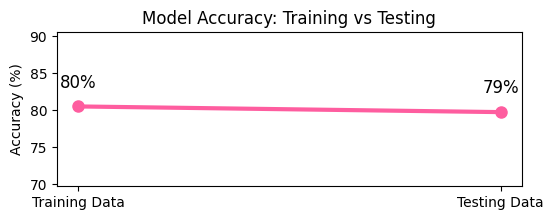

In [42]:
import matplotlib.pyplot as plt

# Data
scores = [dt_grid.score(X_train, y_train) * 100, dt_grid.score(X_test, y_test) * 100]
labels = ['Training Data', 'Testing Data']

# Create a figure with smaller size
plt.figure(figsize=(6, 2))  # Adjust the width and height as needed

# Plot with pastel pink color for the line
plt.plot(labels, scores, marker='o', color='#FE5D9F', linestyle='-', linewidth=3, markersize=8)

# Set the Y-axis limits to center the line
plt.ylim(min(scores) - 10, max(scores) + 10)  # Adjust this to make sure the line is centered within the plot

# Add labels and title
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy: Training vs Testing')

# Adding the text on the plot
for i in range(len(scores)):
    plt.text(labels[i], scores[i] + 2, f'{int(scores[i])}%', ha='center', va='bottom', fontsize=12)

plt.show()


In [20]:
predictions = dt_grid.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   [0 0 0 0 0 1 0 0 0 1]
First 10 Actual labels: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


In [21]:
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)

,Prediction,Actual
0,0,1
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2995,1,0
2996,0,0
2997,1,0
2998,0,0


In [22]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[1979  410]
 [ 198  413]]


In [23]:
cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
print(cm)

[[0.83 0.17]
 [0.32 0.68]]


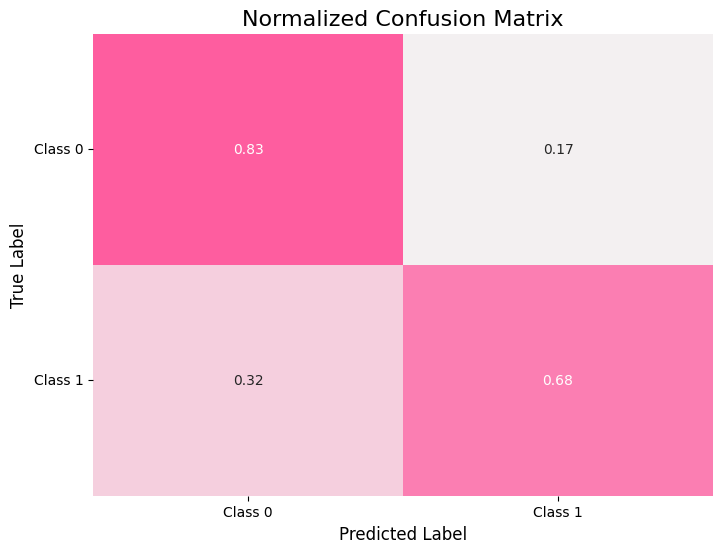

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example normalized confusion matrix
cm = np.array([[0.83, 0.17], 
               [0.32, 0.68]])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap=sns.light_palette("#FE5D9F", as_cmap=True), cbar=False)

# Add labels, title, and axes
plt.title('Normalized Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(ticks=[0.5, 1.5], labels=['Class 0', 'Class 1'], fontsize=10)
plt.yticks(ticks=[0.5, 1.5], labels=['Class 0', 'Class 1'], fontsize=10, rotation=0)

plt.show()


In [24]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87      2389
           1       0.50      0.68      0.58       611

    accuracy                           0.80      3000
   macro avg       0.71      0.75      0.72      3000
weighted avg       0.83      0.80      0.81      3000



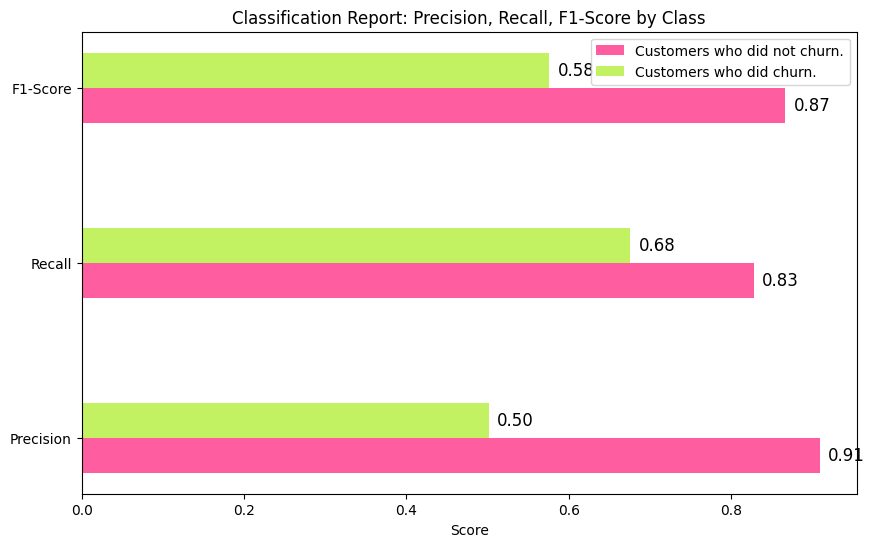

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Sample classification report data
report = classification_report(y_test, predictions, output_dict=True)

# Extract precision, recall, and f1-score for each class
precision_class_0 = report['0']['precision']
recall_class_0 = report['0']['recall']
f1_class_0 = report['0']['f1-score']

precision_class_1 = report['1']['precision']
recall_class_1 = report['1']['recall']
f1_class_1 = report['1']['f1-score']

# Set up the positions for each bar
metrics = ['Precision', 'Recall', 'F1-Score']
class_0_values = [precision_class_0, recall_class_0, f1_class_0]
class_1_values = [precision_class_1, recall_class_1, f1_class_1]

# Bar colors
class_0_color = '#FE5D9F'  # Purple for class 0
class_1_color = '#C2F261'  # Olive for class 1

# Set the figure size
plt.figure(figsize=(10, 6))

# Create horizontal bars
bar_width = 0.2  # Reduced width of bars
index = np.arange(len(metrics))  # Position for each metric

# Plot bars for class 0 and class 1, side by side
bars_class_0 = plt.barh(index - bar_width / 2, class_0_values, bar_width, label='Customers who did not churn.', color=class_0_color)
bars_class_1 = plt.barh(index + bar_width / 2, class_1_values, bar_width, label='Customers who did churn.', color=class_1_color)

# Add labels and title
plt.xlabel('Score')
plt.title('Classification Report: Precision, Recall, F1-Score by Class')
plt.yticks(index, metrics)  # Set y-axis to show metrics
plt.legend()

# Adding text labels for the values on top of the bars
for i, bar in enumerate(bars_class_0):
    # Add value for class 0
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, 
             f'{class_0_values[i]:.2f}', va='center', ha='left', fontsize=12, color='black')

for i, bar in enumerate(bars_class_1):
    # Add value for class 1
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, 
             f'{class_1_values[i]:.2f}', va='center', ha='left', fontsize=12, color='black')

# Display the plot
plt.show()


In [25]:
pred = dt_grid.predict(X_test[:1])

In [26]:
print(f"Predicted classes: {pred}")
print(f"Actual Labels: {list(y_test[:1])}")

Predicted classes: [0]
Actual Labels: [1]


In [27]:
import joblib

filename = '../models/nate_decision_tree.sav'
joblib.dump(dt_grid, filename)

['../models/nate_decision_tree.sav']

In [28]:
dt_model = joblib.load(filename)
print(dt_model.score(X_test, y_test))

0.7973333333333333


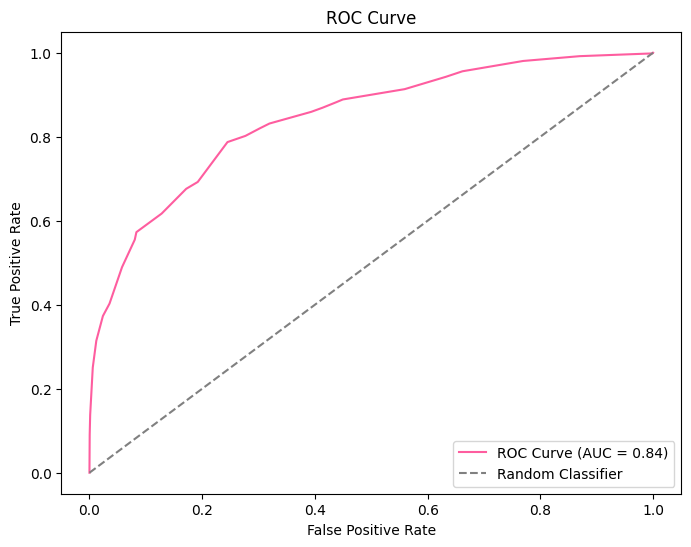

In [30]:
# Importing necessary libraries for ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class
y_pred_proba = dt_grid.predict_proba(X_test)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#FE5D9F', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')

# Adding labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


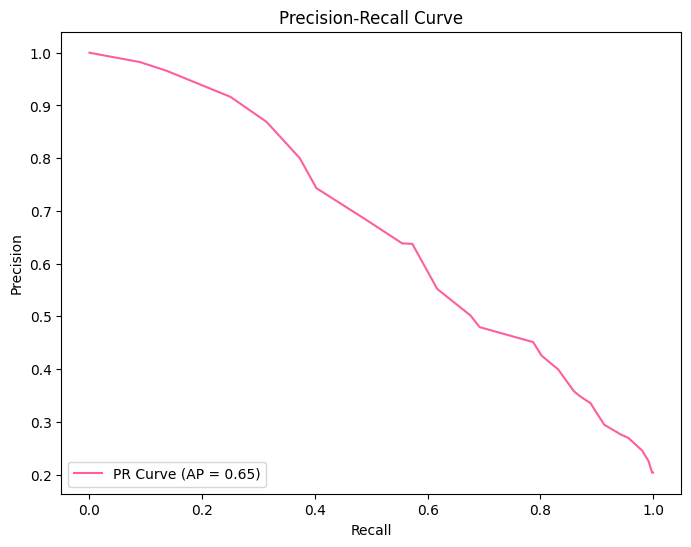

In [31]:
# Importing necessary libraries for Precision-Recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class
y_pred_proba = dt_grid.predict_proba(X_test)[:, 1]

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Compute the Average Precision Score
average_precision = average_precision_score(y_test, y_pred_proba)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='#FE5D9F', label=f'PR Curve (AP = {average_precision:.2f})')

# Adding labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


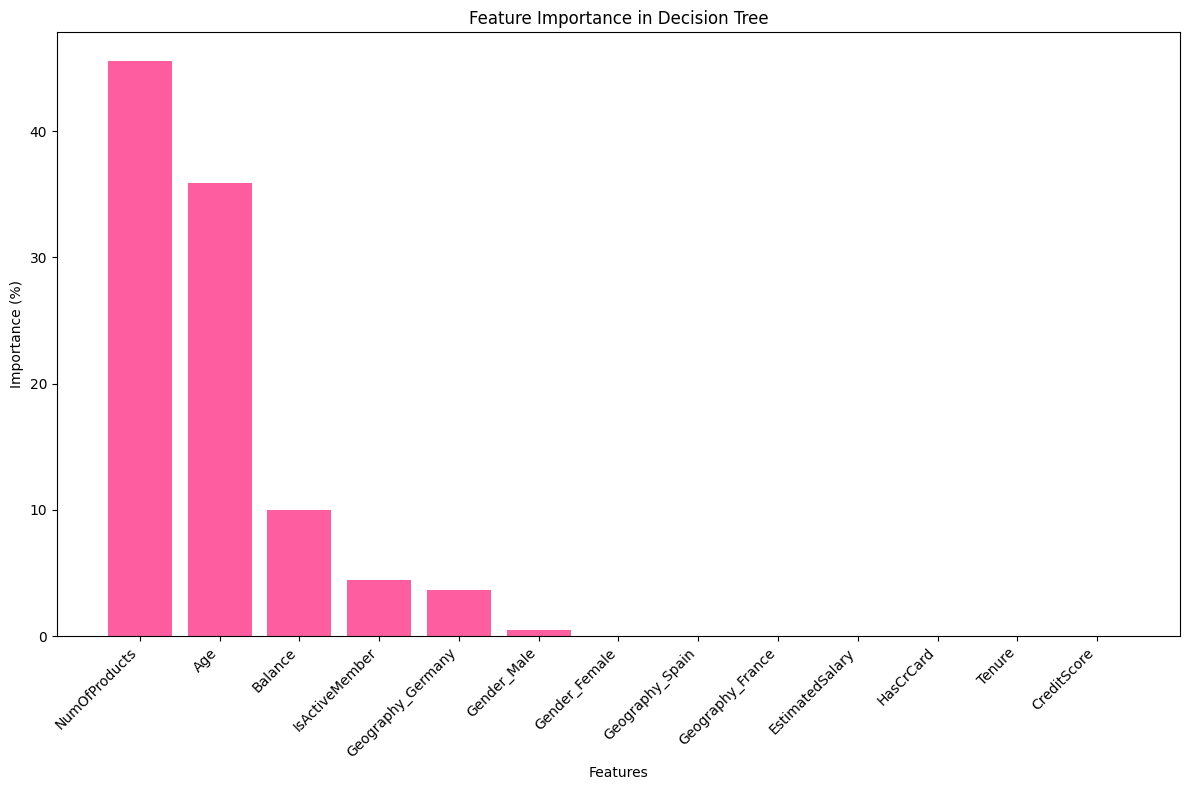

In [45]:
def plot_decision_tree_feature_importance(model, original_num_features, original_cat_features, X_train):
    """
    Plots a feature importance graph based on the decision tree's feature importance.

    Parameters:
    model : Trained decision tree model (GridSearchCV object)
    original_num_features : List of original numerical feature names
    original_cat_features : List of original categorical feature names
    X_train : Training data (used to fit the preprocessor)
    """
    # Access the pipeline
    pipeline = model.best_estimator_

    # Extract the preprocessor and decision tree components
    preprocessor = pipeline.named_steps['columntransformer']
    decision_tree_model = pipeline.named_steps['decisiontreeclassifier']

    # Get the transformed feature names from the preprocessor
    # Use `get_feature_names_out` for one-hot encoded features
    num_feature_names = original_num_features
    cat_feature_names = preprocessor.named_transformers_['onehotencoder'].get_feature_names_out(original_cat_features)

    # Combine numerical and one-hot encoded categorical feature names
    all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

    # Extract feature importances and normalize them
    importances = decision_tree_model.feature_importances_
    importance = 100 * (importances / np.sum(importances))

    # Sort features by importance
    sorted_idx = np.argsort(importance)[::-1]
    sorted_features = all_feature_names[sorted_idx]
    sorted_importance = importance[sorted_idx]

    # Plot the feature importance
    plt.figure(figsize=(12, 8))
    plt.bar(sorted_features, sorted_importance, color='#FE5D9F')
    plt.xlabel("Features")
    plt.ylabel("Importance (%)")
    plt.title("Feature Importance in Decision Tree")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# Call the function with necessary arguments
plot_decision_tree_feature_importance(dt_grid, num_columns, cat_columns, X_train)
